<h1>Classification of  Customers based on Policy Purchase </h1>

<h2> Problem Statement </h2>
Predicting which customers will purchase a given quote</b>

<h3>Performance Metric</h3>
https://www.kaggle.com/competitions/homesite-quote-conversion/overview/

* Area under the ROC curve



### Data Loading 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


In [220]:
!kaggle competitions download -c homesite-quote-conversion #-f train.csv.7z

homesite-quote-conversion.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
##unzipping the data
#https://askubuntu.com/questions/219392/how-can-i-uncompress-a-7z-file
!sudo apt install p7zip-full -y
!7z x homesite-quote-conversion.zip

In [ ]:
!7z x train.csv.zip

In [ ]:
!7z x test.csv.zip

In [ ]:
!pip install missingno

### Train data Analysis

In [2]:
#Reading the train file
df= pd.read_csv("train.csv")

In [4]:
df.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,...,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,...,18,22,-1,10,-1,11,-1,12,N,IL


In [5]:
print(df.columns)
print("\nShape of train matrix:",df.shape)

Index(['QuoteNumber', 'Original_Quote_Date', 'QuoteConversion_Flag', 'Field6',
       'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12',
       ...
       'GeographicField59A', 'GeographicField59B', 'GeographicField60A',
       'GeographicField60B', 'GeographicField61A', 'GeographicField61B',
       'GeographicField62A', 'GeographicField62B', 'GeographicField63',
       'GeographicField64'],
      dtype='object', length=299)

Shape of train matrix: (260753, 299)


The value count from target table are:
 0    211859
1     48894
Name: QuoteConversion_Flag, dtype: int64




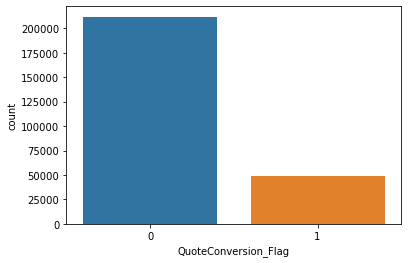

In [6]:
#target column
#checking class count
""" Class imbalance exist. As more number of 0 labels present than 1"""
print("The value count from target table are:\n",df['QuoteConversion_Flag'].value_counts())
print("\n")
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df["QuoteConversion_Flag"])
plt.show()

In [7]:
print("Percentage of  class 0 label train datapoints: ",round(df['QuoteConversion_Flag'].value_counts()[0]*100/df['QuoteConversion_Flag'].count(),2),"%")
print("Percentage of  class 1 label train datapoints: ",round(df['QuoteConversion_Flag'].value_counts()[1]*100/df['QuoteConversion_Flag'].count(),2),"%")

Percentage of  class 0 label train datapoints:  81.25 %
Percentage of  class 1 label train datapoints:  18.75 %


### Observation from train data look up:
* Train dataset is highly imbalanced and having class 0 with 81.25% of datapoints
* Here "Field10" column is having values as integers but numbers in 1000 places are separated by comma's So df['Field10'] column datatype becomes "object" which is string
* Comma's can be removed and converted into integres by typecasting

#### Converting Categorical variables which are having only 2 distinct values( Y & N) to Numerical variables by replacing Y with 1 and N with 0

* Since it doesnot create any data leakage issue so this conversion can be made before split into train and test data

In [8]:
def converting_numeric(df):
  """ This function is to convert the categorical features which are having only Y & N as the categories 
  in the columns can be converted into numerical values as 1 & 0 respectively """
  cat_features=[i for i in df.columns if df.dtypes[i]=='object']
  print("categorical features are:",cat_features)
  print("\n Total number of categorical features are: ",len(cat_features))

  #from the dataset it is observed that colum "GeographicField63" is having NULL value in the unique set of values along with Y & N
  filtered_cat=[]
  for i in cat_features:
    filter_1=dict(df[i].value_counts()) #gives the distinct values
    if len(filter_1)==2 or set(i for i in filter_1.keys() if i!= " ")==set(('N','Y')): #here column having only Y & N are filtered out
      filtered_cat.append(i)

  print("\n{} categorical varibales are converted into numerical features out of {} categorical variables".format(len(filtered_cat),len(cat_features)))
  print("\nConverting categorical variables are: ",filtered_cat)

  df_1=pd.DataFrame([])
  for i in filtered_cat:
    df_1[i]=df[i].map(lambda x: 0 if x== 'N' else(1 if x=='Y' else x)) #writing elif in lambda function from ref
  return df_1,filtered_cat


In [9]:
df_1,filtered_cat=converting_numeric(df)
df=df.drop(filtered_cat, axis=1)
df=pd.concat([df,df_1],axis=1)
print("\n Dimension of the dataframe now is: ",df.shape)

categorical features are: ['Original_Quote_Date', 'Field6', 'Field10', 'Field12', 'CoverageField8', 'CoverageField9', 'SalesField7', 'PersonalField7', 'PersonalField16', 'PersonalField17', 'PersonalField18', 'PersonalField19', 'PropertyField3', 'PropertyField4', 'PropertyField5', 'PropertyField7', 'PropertyField14', 'PropertyField28', 'PropertyField30', 'PropertyField31', 'PropertyField32', 'PropertyField33', 'PropertyField34', 'PropertyField36', 'PropertyField37', 'PropertyField38', 'GeographicField63', 'GeographicField64']

 Total number of categorical features are:  28

12 categorical varibales are converted into numerical features out of 28 categorical variables

Converting categorical variables are:  ['Field12', 'PersonalField7', 'PropertyField3', 'PropertyField4', 'PropertyField5', 'PropertyField30', 'PropertyField32', 'PropertyField34', 'PropertyField36', 'PropertyField37', 'PropertyField38', 'GeographicField63']

 Dimension of the dataframe now is:  (260753, 299)


#### Note: Here still "GeographicField63" column will be string datatype since it is having empty values in it. So it is coming under categorical.

In [10]:
#https://stackoverflow.com/questions/39461328/in-pandas-what-does-the-na-action-parameter-to-series-map-do
def removal_of_empty_if(df_1):
  """converting empty values to None so that this will fall into int64 datatype 
     This can be used for the column which have empty values making the column as string eventhough the rest of the values are integer"""
  if df_1.dtype=='O':
      df_trial=df_1.map(lambda x: int(x) if x!=' ' else None ,na_action=None)
      print("Datatype after conversion is: ",df_trial.dtype)
      #now check the converted 
      if df_trial.dtype=='int64' or df_trial.dtype=='float64':
        return df_trial
      else:
        print("\nThe given column has other categories than empty value")

In [11]:
df_none=removal_of_empty_if (df['GeographicField63'])

Datatype after conversion is:  float64


In [12]:
df=df.drop(['GeographicField63'],axis=1) #removing the string column
if df_none.dtype=='int64' or df_none.dtype=='float64':
  df['GeographicField63']=df_none
else:
  print("\n undrop the column")
#df=pd.concat([df,df_none],axis=1) #concatening the converted numerical column

#### Comma character removal and integer conversion of "Field10" column

In [13]:
def comma_removal(column_comma):
  """converting catergorical feature into numerical. As it is having comma for 1000position of number in the column values """
  print("The current dtatype is:", column_comma.dtype)
  if column_comma.dtype=='O': #checks if the datatype is object then perform the comma removal
    column_comma=column_comma.apply(lambda x: int(x.replace(',',"")))
    print("The dtatype after conversion is:" ,column_comma.dtype)
    return column_comma
  else:
    return column_comma


In [14]:
#Updating the "Field10" column by removing the comma at 1000's places and converting into integer
df["Field10"] = comma_removal(df["Field10"])


The current dtatype is: object
The dtatype after conversion is: int64


### Finding Categorical feature correlation using Chi-Square test

##### References
* https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas
* https://www.geeksforgeeks.org/python-pearsons-chi-square-test/
* https://www.geeksforgeeks.org/pandas-crosstab-function-in-python/

In [15]:
#https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/
cat_features=[i for i in df.columns if df.dtypes[i]=='object']
from scipy.stats import chi2_contingency
"""Cross tab function calculates the frequency between the pair of categorical variables"""
from scipy.stats import chi2_contingency
pair_columns=list()
for i in cat_features:
  for j in cat_features:
    if (j,i) not in pair_columns: #and i!=j: #takes only combination of pairs 
      pair_columns.append((i,j))

correlated_col=[]
p_value_corr=[]
for i in pair_columns:
 
  CrosstabResult=pd.crosstab(index=df[i[0]],columns=df[i[1]])
  #print(CrosstabResult)
  #Performing Chi-sq test
  chi2, p, dof, ex = chi2_contingency(CrosstabResult)
  # P-Value is the Probability of H0 being True
  # If P-Value;0.05 then only we Accept the assumption(H0)

  #print('The P-Value of the ChiSq Test is for pair {} is :'.format(i), p)
  """  A p-value measures the probability of obtaining the observed results, assuming that the null hypothesis is true."""
  if p<=0.05:
    correlated_col.append(i)
    p_value_corr.append(p)


In [16]:
dict_1=dict(zip(correlated_col,p_value_corr))
zero_cat_df=pd.DataFrame(0,columns=cat_features,index=cat_features)
set_1=set()
set_2=set()
for key, value in dict_1.items():
  zero_cat_df.loc[key[0],key[1]]=round(value,3)
  zero_cat_df.loc[key[1],key[0]]=round(value,3)
  set_1.add(key[0])
  set_2.add(key[1])


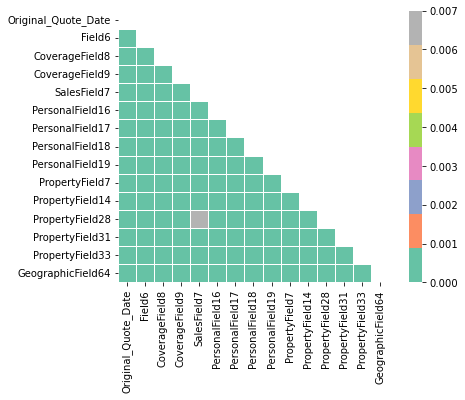

In [17]:
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
import seaborn as sns
mask = np.zeros_like(zero_cat_df)
#np.triu_indices_from will get the values from upper triangle matrix
mask[np.triu_indices_from(mask)] = True #data will not be shown in heatmap where mask is TRUE
sns.axes_style("white")
f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(zero_cat_df, mask=mask, cmap="Set2",square=True,linewidth=0.8)

### Observations:
* There are total 15 categorical features
* Null Hypothesis(H0): There is no correlation among the features
* Alternative Hypothesis(H1): There exists correlation among the features/columns
* Significance value(alpha) is 0.05 is choosen for an analysis
* For all the pairs for features p value is less than 0.05. It means we reject NULL Hypothesis and accept alternative hypothesis saying that all the pairs/combination of categorical features are correlated
* So here for dropping columns. Count method is considered. Higher the unique fields columns can be dropped and will retains 7 columns amoung 15 columns

In [18]:
set_1.remove('Original_Quote_Date')

In [19]:
describe=df[list(set_1)].describe()[1:2].T

In [20]:
#list o correlated columns to be dropped which have high correlation with other columns
dropping_cat_feat=list(describe.sort_values(by=['unique'],ascending=False, ignore_index=False)[:7].index)
print("dropping columns which are positively correlated: ",dropping_cat_feat)

dropping columns which are positively correlated:  ['PersonalField17', 'PersonalField18', 'PersonalField19', 'PersonalField16', 'PropertyField7', 'CoverageField9', 'Field6']


In [21]:
df=df.drop(dropping_cat_feat,axis=1)
print("Dimension is : ",df.shape)

Dimension is :  (260753, 292)


* Here 'Original_Quote_Date' columns are not removed currently but is removed while extracting the new features. So considering 14 remaining columns of categorical types. 7 more are removed

### Analysing columns with higher NA's count

In [24]:
#https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical
#https://stackoverflow.com/questions/36226083/how-to-find-which-columns-contain-any-nan-value-in-pandas-dataframe#:~:text=You%20can%20use%20df.,isnull().
#https://www.geeksforgeeks.org/matplotlib-pyplot-text-function-in-python/  -->> to add text in graph
#https://stackoverflow.com/questions/71610279/visualise-missing-values-in-a-time-series-heatmap -->>string to float issue
# https://medium.com/@sumitgulati59/insurance-risk-classification-380c805eca0e -->> for missing no graph analysis
def removing_col_NA(df_1,threshold):
  """ Removing the columns which have higher percentage of NA/NULL values in it as they will not give value during classification. 
      Removal of column is done based on input threshold
  
  """
  # Seperating categorical & Numerical column based on "dtype" function & storinf in list
  cat_features=[i for i in df_1.columns if df_1.dtypes[i]=='object']
  numerical_features=list(set(df_1.columns)-set(cat_features))

  #Checking if column has atleast one NA value in it in -the dataset
  print("The columns/features which have atleast one NULL value are:\n",df_1.columns[df_1.isnull().any()])

  #Count of NA values in the columns & result is stored in dictionary
  null_count=dict(df_1[df_1.columns[df_1.isnull().any()]].apply(lambda x: x.isna().sum()))
  print("\nCount of NA values in the columns are: \n",null_count)
  #Percentage of NA are calculated baed on "QuoteConversion_Flag" column
  percentage_NA=dict(df_1[df_1.columns[df_1.isnull().any()]].apply(lambda x: round(x.isna().sum()*100/(df_1['QuoteConversion_Flag'].count()),2)))
  sorted_NA=sorted(percentage_NA.items(),key=lambda a: a[1]) #sorting based on percentage of NA in asc. 

  #NA graph
  import matplotlib.pyplot as plt
  """ Bar graph for columns having NA values"""
  values=[]
  keys=[]
  for i  in sorted_NA:
    values.append(i[1])
    keys.append(i[0])
  plt.bar(keys,values)
  plt.xticks(fontsize=10,rotation=90)
  plt.yticks(fontsize=10)

  for a,b in zip(keys, values):  #to add the value in the graph 
      plt.text(a, b, str(b))
  plt.ylabel("Count")
  plt.title("Coulms with NA fields")
  plt.show()

  #correlation graph
  print('\n')
  import missingno as msno
  fig, ax =plt.subplots(figsize = (8,5))
  fig =msno.heatmap(df_1[keys],ax=ax)
  plt.xticks(fontsize=10,rotation=90) #educing the fontsize and rotating the label to 90degree
  plt.yticks(fontsize=10)
  ax.set_title("\n Missing values Correlation plot")
  plt.show()

  # Applying threshold based on the model performance
  a=[values.index(i) for i in values if i>= threshold]  #filtering with theshold & extracting the index
  drop_columns_na= [keys[i] for i in a ] #storing dropping columns of na in list
  print("\n Columns need to be analysed for dopping are: : ",drop_columns_na)

  # Null count for dropping column for converted & non converted cusomer is
  for i in drop_columns_na:
    print("Null count for converted & non converted customer on {} column is\n".format(i),df_1["QuoteConversion_Flag"][df_1[i].isnull()].value_counts())

  #dropping the NA column having percentage more than threshold
  #df_1= df_1.drop(drop_columns_na,axis=1)
  #print("\nThe dimenson now is :",df_1.shape)
  #return df_1
  return drop_columns_na,null_count


The columns/features which have atleast one NULL value are:
 Index(['PersonalField84', 'PropertyField29', 'PersonalField7',
       'PropertyField3', 'PropertyField4', 'PropertyField32',
       'PropertyField34', 'PropertyField36', 'PropertyField38',
       'GeographicField63'],
      dtype='object')

Count of NA values in the columns are: 
 {'PersonalField84': 124208, 'PropertyField29': 200685, 'PersonalField7': 113, 'PropertyField3': 81, 'PropertyField4': 63, 'PropertyField32': 70, 'PropertyField34': 70, 'PropertyField36': 113, 'PropertyField38': 1220, 'GeographicField63': 2}


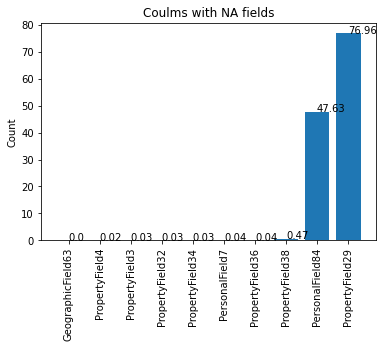

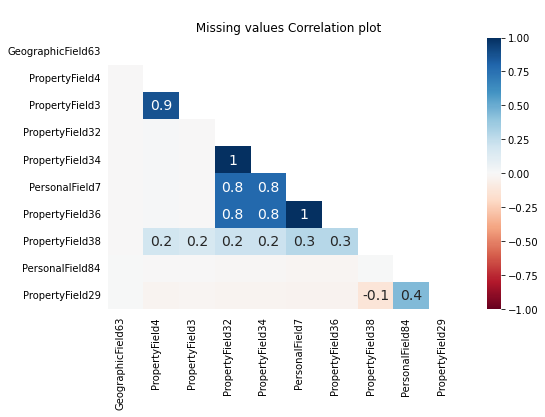


 Columns need to be analysed for dopping are: :  ['PropertyField29']
Null count for converted & non converted customer on PropertyField29 column is
 0    151795
1     48890
Name: QuoteConversion_Flag, dtype: int64


In [25]:
#after the analysis the threshold is taken as 75%
drop_columns_na_train,null_count = removing_col_NA(df,75)

#### Observation:

* There are total 9 columns with atleast having 1 NA value in it.
* PropertyField29 column is having 76.96% of NULL values in it and PersonalField84 column is having 47.63% of NULL values and rest of other columns are having les than 0.5% of NULL values
* PropertyField29 & PersonalField84 columns are further analysed on decision to keep or remove from the features
* For the total count of records "Quote_conversion_flag is considered since we are dealing supervised learing algorithm where records with class label


#### Observation from NA correlation graph

* Below are the high correlated pair of columns for NA values
  1. PropertyField3, PropertyField4 =0.9
  2. PropertyField34,PropertyField32  =1
  3. PropertyField36, PersonalField7 =1
  4. PersonalField7,PropertyField34 =0.8
  5. PersonalField7,PropertyField32 =0.8 
* The values are close to positive 1 indicate that the presence of null values in one column is correlated with the presence of null values in another column

* We obsevre that total of 6 columns from 10 columns are having higher correlation.So PropertyField3, PropertyField4,PropertyField34,PropertyField36,PropertyField32,PersonalField7 columns falls into <b>MCR/MCAR</b> (missing completely at random) category

* 3 columns of Higher NULL count columns are dropped from the pair of correlated features
* Values close to 0, indicate there is little to no relationship between the null values in one column compared to another.

* PropertyField29,PersonalField84 columns are having less correlation with all other missing value columns. So these are independent NULL value columns.And these column are further analysed and dropped from the column if no pattern found with respect to target column. Also percentage of missing values are taken into account

* PropertyField38,GeographicField63 columns are having 0 or less correlation with other NA columns. So these NA records can be imputed.


In [26]:
#there are totally 6 high positively high correlated column are present.
for i in ['PropertyField3', 'PropertyField4','PropertyField34','PropertyField36','PropertyField32','PersonalField7']:
   print(i,"=",null_count[i])

PropertyField3 = 81
PropertyField4 = 63
PropertyField34 = 70
PropertyField36 = 113
PropertyField32 = 70
PersonalField7 = 113


* From the correlated pair of columns, It is observed that the count of missing NULL values are comparatively less than the total count. So It is good to retain these columns and are exposed further for variance and correlation analysis :

### Analysing the "PropertyField29" column over NA & non-NA fields


 count of Label assigned to missing values are: 
 0    151795
1     48890
Name: QuoteConversion_Flag, dtype: int64


[]

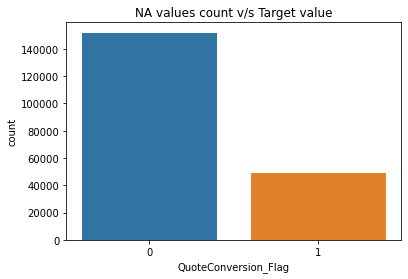

In [27]:
#Here we are analysing how many missing values are representing which target value
a=df['QuoteConversion_Flag'][df['PropertyField29'].isna()]
print("\n count of Label assigned to missing values are: \n",a.value_counts())
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(a)
plt.title("NA values count v/s Target value")
plt.plot()

##### Observation:
* We can see that there are 1,51,795 records are assigned as target value['QuoteConversion_Flag'] 0 for which "PropertyField29" column has no value in it
* And for 48,890 records are assigned as target value 1 for which "PropertyField29" column has no value in it

Conclusion:
* 75.63% of the missing records from the "PropertyField29" column are labelled as 0  and remaining 24.37% as class 1. Which means we have more dataloss for class 0 in this column

##### Analysing for not NaN value for "PropertyField29". Checking the other values distribution over class label

In [28]:
#to check not nan -->>https://stackoverflow.com/questions/2831516/isnotnan-functionality-in-numpy-can-this-be-more-pythonic
#storing the each unique value in list and analysing the contribution towrds the class label
#unique_value=np.zeros(len(np.unique(df['PropertyField29'])))
field_val=[]
class_1=[]
class_0=[]
for j,i in enumerate(np.unique(df['PropertyField29'])) :
  if ~np.isnan(i): #if i is not null value then
    a=dict(df['QuoteConversion_Flag'][df['PropertyField29']==i].value_counts())
    #when filed value is missing for one of the target table so updating by default zero
    class_1.append(0)
    class_0.append(0)
    field_val.append(i)
    if 0 in list(a.keys()): 
      class_0[j]=a[0] 
    if 1 in list(a.keys()):
      class_1[j]=a[1]

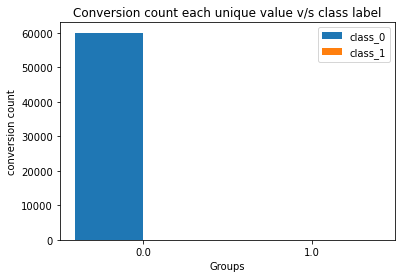

In [29]:
#https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
import numpy as np
import matplotlib.pyplot as plt 
X_axis = np.arange(len(field_val))
plt.bar(X_axis - 0.2, class_0, 0.4, label = 'class_0')
plt.bar(X_axis + 0.2, class_1, 0.4, label = 'class_1') #width=0.4 units 
plt.xticks(X_axis, field_val) #(location,label)
plt.xlabel("Groups")
plt.ylabel("conversion count")
plt.title("Conversion count each unique value v/s class label")
plt.legend()
plt.show()

In [30]:
print("filed values:",field_val)
print("class_0 counts",class_0)
print("class_1 counts",class_1)
total_count= class_0 + class_1
list(zip(field_val,((total_count)/sum(total_count)*100)))

filed values: [0.0, 1.0]
class_0 counts [60056, 8]
class_1 counts [0, 4]


[(0.0, 99.98002264100685), (1.0, 0.013318239328760736)]

##### Observation: 
* This column is having total of 200685 records with NULL values out of 260753 records which comes around 76.96% . So here removing all the records with NULL values is not good idea

* There are 60068(23.04%) records which are having value/non-NA in PropertyField29 column. Among these 60056(99.8%) are having 0.0 value for PropertyField29 column & 12(0.013%) records are having 1.0 value.


* 99.98% percentage of non missing values are assigned as value 0.0. Among these 99.86% percentge values of 0.0 are belongs to class_0 which is highly skewed in terms fo class label assignment as well as distinct value comparison among other values

Conclusion:
* Identified pattern:For missing value imputation records with class 0 can be assigned as 0.0 and for records with class 1 as 1.0 
* However we can see that data is highy skewed of having low variance value(99.9% of non-missing value as 0.0). As data is not spread in making the decision of target value. So this column can be further checked/analysed in low varaince check and can be dropped
* From the missing value correlation graph(NA graph), It is observed that this column is not having relation with other missing values column. So PropertyField29 column can be safely dropped


### Analysing the "PersonalField84" column over NA & non-NA fields


 count of Label assigned to missing values are: 
 0    100126
1     24082
Name: QuoteConversion_Flag, dtype: int64


[]

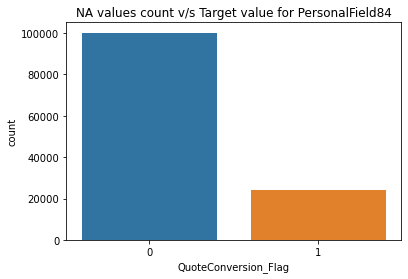

In [31]:
#Here we are analysing how many missing values are representing which target value
a=df['QuoteConversion_Flag'][df['PersonalField84'].isna()]
print("\n count of Label assigned to missing values are: \n",a.value_counts())
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(a)
plt.title("NA values count v/s Target value for PersonalField84")
plt.plot()

#### Observation:
* We can see that there are 1,00,126 records are assigned as target value 0 for which "PersonalField84" column has no value in it
* And for 24,082 records are assigned as target value 1 for which "PersonalField84" column has no value in it

Conclusion:
* 80.61% of the missing records from the "PersonalField84" column are labelled as 0  and remaining as class 1. Which means we have more dataloss for class 0 in this column

#### Analysing for not NaN value for "PersonalField84". Checking the other values distribution over class label

In [32]:
#to check not nan -->>https://stackoverflow.com/questions/2831516/isnotnan-functionality-in-numpy-can-this-be-more-pythonic
#storing the each unique value in list and analysing the contribution towrds the class label
unique_value=np.zeros(len(np.unique(df['PersonalField84'])))
field_val=[]
class_1=[]
class_0=[]
for j,i in enumerate(np.unique(df['PersonalField84'])) :
  if ~np.isnan(i):
    a=dict(df['QuoteConversion_Flag'][df['PersonalField84']==i].value_counts())
    class_1.append(0)
    class_0.append(0)
    field_val.append(i)
    if 0 in list(a.keys()):
      class_0[j]=a[0] 
    if 1 in list(a.keys()):
      class_1[j]=a[1]

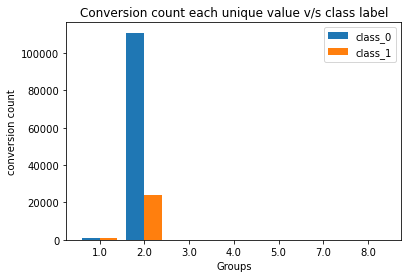

In [33]:
#https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
import numpy as np
import matplotlib.pyplot as plt 
X_axis = np.arange(len(field_val))
plt.bar(X_axis - 0.2, class_0, 0.4, label = 'class_0')
plt.bar(X_axis + 0.2, class_1, 0.4, label = 'class_1') #width=0.4 units 
plt.xticks(X_axis, field_val) #(location,label)
plt.xlabel("Groups")
plt.ylabel("conversion count")
plt.title("Conversion count each unique value v/s class label")
plt.legend()
plt.show()

In [34]:
print("filed values:",field_val)
print("class_0 counts",class_0)
print("class_1 counts",class_1)
total_count= class_0 + class_1
list(zip(field_val,((total_count)/sum(total_count)*100)))

filed values: [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0]
class_0 counts [737, 110957, 3, 0, 34, 1, 1]
class_1 counts [827, 23949, 4, 2, 28, 2, 0]


[(1.0, 0.5397488007616537),
 (2.0, 81.26039034750448),
 (3.0, 0.0021970778864110734),
 (4.0, 0.0),
 (5.0, 0.02490021604599216),
 (7.0, 0.0007323592954703577),
 (8.0, 0.0007323592954703577)]

#### Observation:
* This column is having total of 124208 records with NULL values out of 260753 records which comes around 47.63% 
* 81% percentage of non missing values are assigned as 2. Among these 82.5% percentge values of 2 are belongs to class_0 

Conclusion:
* For missing value imputation records with class 0 can be assigned as 2 by considering the "mode" method.Since the data is not missing completely at random.So values will be imputed for this column

In [35]:
df= df.drop(drop_columns_na_train,axis=1)
print("\ndimension of input now: ",df.shape)


dimension of input now:  (260753, 291)



### Observations

* There are total 9 columns with atleast having 1 NA value in it.
* For the total count of records "Quote_conversion_flag is considered since we are dealing supervised learing algorithm where records with class label

PropertyField29:
*  This column is having total of 200685 records with NULL values out of 260753 records which comes around 76.9% 
* Among 200685 records are splits into 151795 records with NULL values which classify "QuoteConversion_flag to class 0 & other 48890 records with NULL values classifis the "QuoteConversion_flag" to class 1
* The above interpretation does not give any value since NULL does not carry any information on both the classes
* By considering above condition threshold is set to 75 and column is dropped

PersonalField84:
*  This column is having total of 124208 records with NULL values out of 260753 records which comes around 47.63% 
* Among 200685 records are splits into 100126 records with NULL values which classify "QuoteConversion_flag to class 0 & other 24082 records with NULL values classifis the "QuoteConversion_flag" to class 1
* The above interpretation does not give any value since NULL does not carry any information on both the classes. So this column is further exposed to correlation and variance checks

### Removing the feature with low variance

In [36]:
def remove_low_var(df_1,var_threshold):
  """Variance will be calculated for numeric values only """

  # Seperating categorical & Numerical column based on "dtype" function & storinf in list
  cat_features=[i for i in df_1.columns if df_1.dtypes[i]=='object']
  numerical_features=list(set(df_1.columns)-set(cat_features))
  
  var_dict=df_1[numerical_features].var().to_dict() #calculation var of numeric columns and storing in dictionary

  #filtering the features/columns baed on the variance threshold
  below_threshold_keys=[] #storing the columns above variance threshold
  below_threshold_values=[] #storing threshold values
  for i,j in var_dict.items():
    if j<var_threshold:        #var_threshold= 0.001
      below_threshold_keys.append(i)
      below_threshold_values.append(j)

  #printing the threshold columns & values
  print("\n Columns having values below var_threshold:\n", dict(zip(below_threshold_keys,below_threshold_values)))

  #variance bar graph
  print("\nThe Low variance Graph\n")
  import matplotlib.pyplot as plt
  """ Bar graph for columns having variance below than threshold values"""

  plt.bar(below_threshold_keys,below_threshold_values)
  plt.xticks(rotation=90) #adjusting the X labels into 90 degree for better visual
  for a,b in zip(below_threshold_keys, below_threshold_values): 
    plt.text(a, b, str(round(b,4)))
  plt.ylabel("Variance")
  plt.title("Coulms with Zero Variance ")
  plt.show()

  return below_threshold_keys,var_dict



 Columns having values below var_threshold:
 {'PropertyField6': 0.0, 'PersonalField65': 0.0006285829519531464, 'PersonalField66': 0.0008162739318116953, 'PropertyField5': 0.0004446692474385784, 'PersonalField8': 0.0001572151580565965, 'PersonalField64': 0.0004753287382687196, 'GeographicField10A': 0.0, 'PersonalField69': 0.0007131802180194005, 'PropertyField20': 9.970683808670657e-05, 'PropertyField9': 8.053204451520408e-05, 'Field9': 2.207506609201729e-06}

The Low variance Graph



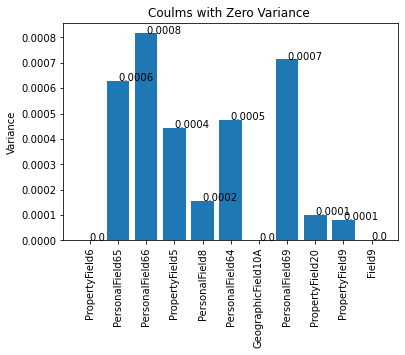

 dimension of input now:  (260753, 280)


In [37]:
below_threshold_keys,var_dict = remove_low_var(df,0.001)
df= df.drop(below_threshold_keys,axis=1)
print(" dimension of input now: ",df.shape)


### Observations
* Here variance threshold is set to 10^-3 which can be increased or decreased based on the model performace
* There are total of 11 features are having variance less than or equals to 10-3 values. Maximum values are repeated in the columns


### Removing the columns which has very High variance/More distinct values

In [38]:
def remove_high_var(df_1,var_dict,high_var_threshold):
  """ Removing the columns having high variance or having more distinct values"""
  # Seperating categorical & Numerical column based on "dtype" function & storinf in list
  cat_features=[i for i in df_1.columns if df_1.dtypes[i]=='object']
  numerical_features=list(set(df_1.columns)-set(cat_features))

  #based on the threshold value removing the columns
  high_var_keys=[]
  high_var_values=[]
  for i, j in var_dict.items():
    if j>high_var_threshold and len(df[i].value_counts()) > 10 : # here length parameter cares about the distinct values ,high_var_threshold=100
      high_var_keys.append(i)
      high_var_values.append(j)

  print("Listing the high variance columns & values for above threshold",list(zip(high_var_keys,high_var_values)))

  #variance bar graph
  print("\nThe High variance Graph\n")
  import matplotlib.pyplot as plt
  """ Bar graph for columns having higher variance values"""

  plt.bar(high_var_keys,high_var_values)
  plt.xticks(rotation=90) #adjusting the X labels into 90 degree for better visual
  for a,b in zip(high_var_keys, high_var_values): 
    plt.text(a, b, str(round(b,2)))
  plt.ylabel("Variance")
  plt.title("Coulms with High Variance ")
  plt.show()


  return high_var_keys

Listing the high variance columns & values for above threshold [('QuoteNumber', 15744859642.268942), ('SalesField8', 378074846.7725287)]

The High variance Graph



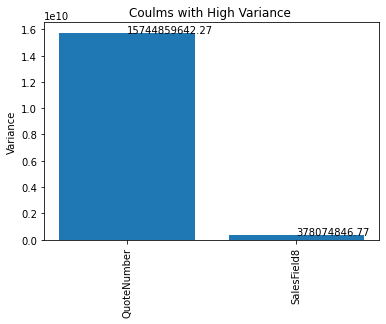


dimension of input now:  (260753, 278)


In [39]:
high_var_keys = remove_high_var(df,var_dict,100)
df= df.drop(high_var_keys,axis=1)
print("\ndimension of input now: ",df.shape)

### Observation
* After looking at some sample records for each columns. Threshold selected as 100 and length of distinct value is set as more than 10 in which there are 2 column with high variance.
* "QuoteNumber" is the customer identification number which is unque for each record. So this does not give any information and can be dropped
* 'SalesField8' column is having high variance among all the columns. So it can alo be dropped 
* 'Field10' has high variance but it has less distinct values in it. So it can be categorised. So standardization is applied on this column

#### Removing the highly correlated features 

In [40]:
def remove_corr_col(df_1,corr_threshold):
  """ Removing the correlated features"""
  # Seperating categorical & Numerical column based on "dtype" function & storinf in list
  cat_features=[i for i in df_1.columns if df_1.dtypes[i]=='object']
  numerical_features=list(set(df_1.columns)-set(cat_features))

  #calculation correlation for numericl features
  corr_matrix=df_1[numerical_features].corr()

  """It is the square matrix so indices values for i,j =j,i
  Also here diagonal elements are removed  
  ex: corr_threshold = 0.99"""
  import numpy as np
  upper_triangle=np.triu(corr_matrix ,1) #upper triangular matrix
  indices=np.where(abs(upper_triangle)>corr_threshold) #it gives the indices of "TRUE" values in the rows & columns array respectively

  #storing only highly correlted column values
  Correlted_value=upper_triangle[indices]

  indices_99_corr=np.stack((indices[0],indices[1])).flatten() #stacking the indices of correlated columns(combining row/column indices)
  all_corr_columns=len(corr_matrix.columns[list(set(indices_99_corr))]) #getting the length of correlated columns
  print("\nThe {} % correlated columns count is: ".format(corr_threshold*100),all_corr_columns) 

  #storing the correlated column pairs & values in dictionary
  storage=dict()
  for i in range(len(indices[0])):
    storage[(corr_matrix.columns[indices[0][i]],corr_matrix.columns[indices[1][i]])]=Correlted_value[i] #(row,column)= correlated_value
  print("\n the correlated pairs of columns nd values are: \n",storage)

  #Selecting the features among the correlated pairs
  set1=set()
  set2=set()
  drop_columns_corr=[]
  for i in range(len(indices[0])): #iterating over indices
    set1.add(corr_matrix.columns[indices[0][i]]) #getting the column names from first pair
    set2.add(corr_matrix.columns[indices[1][i]]) #getting the column names from second pair
  
  if len(set1)>len(set2): #here choosing the minimum number of columns to retain & removing the maximum side of correlated features
    drop_columns_corr.append(list(set2))
  elif len(set1)< len(set2):
    drop_columns_corr.append(list(set2)) 
  else:
    drop_columns_corr.append(list(set1))

  print("\n Correlation graph for threshold columns")
  import seaborn as sns
  fig, ax = plt.subplots(figsize=(15,10)) 
  sns.heatmap(corr_matrix.iloc[list(indices_99_corr),list(indices_99_corr)], cmap="YlGnBu",linewidths=0.8,ax=ax)
  plt.show()
  
  print("Among {} correlated columns {} columns are dropped".format(all_corr_columns,len(drop_columns_corr[0])))
  print("\nThe dropping correlated column are: ",drop_columns_corr[0])

  #df_1=df_1.drop(drop_columns_corr[0],axis=1)
  #print("Shape of dataframe now is: ",df_1.shape)
  return drop_columns_corr[0]



The 99.0 % correlated columns count is:  20

 the correlated pairs of columns nd values are: 
 {('GeographicField11A', 'GeographicField13A'): 0.9973230894984385, ('GeographicField11A', 'GeographicField8A'): 0.994179781884102, ('GeographicField11A', 'GeographicField6A'): 0.9942259289495805, ('GeographicField7B', 'GeographicField12B'): 0.9954205027425153, ('GeographicField3A', 'GeographicField3B'): 0.9917245814376491, ('GeographicField52B', 'GeographicField52A'): 0.9907507713250117, ('GeographicField52B', 'GeographicField51B'): 0.9901664205536312, ('GeographicField2A', 'GeographicField2B'): 0.9915598126577991, ('GeographicField13A', 'GeographicField8A'): 0.9960264064833747, ('GeographicField13A', 'GeographicField6A'): 0.9922009476400099, ('GeographicField52A', 'GeographicField51A'): 0.990052081234909, ('PropertyField21B', 'CoverageField1B'): 0.9963897788431348, ('CoverageField1A', 'PropertyField21A'): 0.9957095943453519, ('GeographicField8A', 'GeographicField6A'): 0.9962764597341486, ('

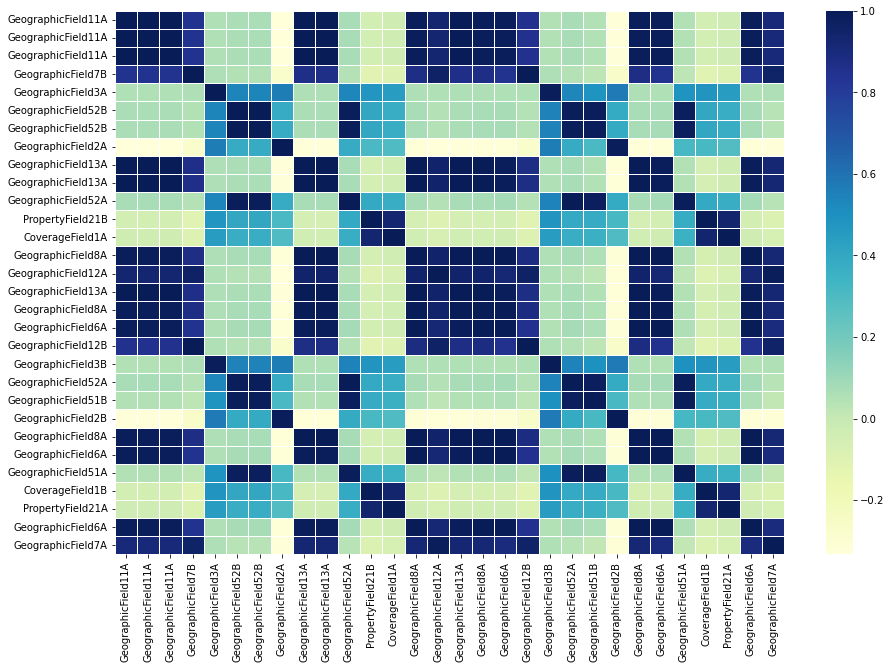

Among 20 correlated columns 12 columns are dropped

The dropping correlated column are:  ['GeographicField51B', 'CoverageField1B', 'GeographicField12B', 'GeographicField13A', 'GeographicField6A', 'PropertyField21A', 'GeographicField8A', 'GeographicField7A', 'GeographicField51A', 'GeographicField52A', 'GeographicField2B', 'GeographicField3B']

dimension of input now:  (260753, 266)


In [41]:
drop_columns_corr = remove_corr_col(df,0.99)
df= df.drop(drop_columns_corr,axis=1)
print("\ndimension of input now: ",df.shape)

#### Observations
* Here correlation threshold is set to 0.99 which can be decreased based on the model performace
* There are total of 20 features are having high correlation among each other. Among them 12 features are removed. Here for dropping the columns, priority is taken based on the length of right & left side elements. Keeping the minimum number of columns helps in reducing the dimension.

In [42]:
#dropped column from all the above analysis
dropped_columns =  below_threshold_keys + high_var_keys + drop_columns_corr +drop_columns_na_train+dropping_cat_feat
print("The number of columns are dropped from original features are : ", len(dropped_columns))

The number of columns are dropped from original features are :  33


Observation:
* Total 33 columns are dropped from the above feature engineering analysis.

In [43]:
#https://stackoverflow.com/questions/899103/writing-a-list-to-a-file-with-python
import pickle
with open("dropped_columns", "wb") as fp:   #Pickling
  pickle.dump(dropped_columns, fp)

In [44]:
import pickle
with open ('dropped_columns', 'rb') as fp:
    itemlist = pickle.load(fp)
    

### Standardizing the float value

In [45]:
cat_features=[i for i in df.columns if df.dtypes[i]=='object']
numerical_features=list(set(df.columns)-set(cat_features))

In [46]:
#https://stackoverflow.com/questions/34148815/check-if-a-pandas-series-has-at-least-one-item-greater-than-a-value
std_threshold =25
std_columns=[]
for i in numerical_features:
  if (df[i]>std_threshold).any():
    std_columns.append(i)
print(std_columns)  

['Field7', 'SalesField11', 'Field10', 'PersonalField14', 'SalesField12']


In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df[std_columns])
df[std_columns]=scaled

In [48]:
print("train input data: ",df.shape)

train input data:  (260753, 266)


### Feature Engineering & EDA

* Extracting information from "Original_Quote_Date" column(Month, year,Day,week of the year)
* Analysing the data with FULL train data

In [49]:
#https://stackoverflow.com/questions/56152408/how-to-convert-string-to-numpy-datetime64-from-a-dataframe
#https://www.programiz.com/python-programming/datetime/strftime  -->> to know the syntax of strftime

def extract_date_feat(df_1):
  """ Converting string values to datetime64 datatype
  strftime is used to convert the date into string        """
  df_1["date"]=df_1['Original_Quote_Date'].map(lambda i: int(i.strftime("%d")))
  df_1["weekday_name"]=df_1['Original_Quote_Date'].map(lambda i : i.strftime("%A"))
  df_1["month"]=df_1['Original_Quote_Date'].map(lambda i : int(i.strftime("%m")))
  df_1["year"]=df_1['Original_Quote_Date'].map(lambda i : int(i.strftime("%Y")))

  return df_1

In [52]:
df['Original_Quote_Date'] = pd.to_datetime(df['Original_Quote_Date']) #converting to datetime
print(df['Original_Quote_Date'].dtype)
extract_date_feat(df).head() #direct update of columns in the dataframe

datetime64[ns]


,Original_Quote_Date,QuoteConversion_Flag,Field7,Field8,Field10,Field11,CoverageField1A,CoverageField2A,CoverageField2B,CoverageField3A,...,PropertyField32,PropertyField34,PropertyField36,PropertyField37,PropertyField38,GeographicField63,date,weekday_name,month,year
0,2013-08-16,0,0.637518,0.9403,0.037475,1.0200,17,17,23,15,...,1.0,1.0,0.0,0,0.0,0.0,16,Friday,8,2013
1,2014-04-22,0,-1.529685,1.0006,-1.397630,1.2433,6,6,8,5,...,0.0,1.0,0.0,0,0.0,0.0,22,Tuesday,4,2014
2,2014-08-25,0,-1.529685,1.0006,-1.397630,1.2433,7,7,12,6,...,1.0,1.0,0.0,0,0.0,0.0,25,Monday,8,2014
3,2013-04-15,0,-1.123334,0.9769,0.725775,1.2665,3,3,2,2,...,1.0,0.0,0.0,1,0.0,0.0,15,Monday,4,2013
4,2014-01-25,0,0.637518,0.9472,1.833937,1.3045,8,8,13,7,...,0.0,0.0,0.0,0,0.0,0.0,25,Saturday,1,2014


In [53]:
print("The dimension after addiion of 4 columns: ",df.shape)

The dimension after addiion of 4 columns:  (260753, 270)


In [54]:
cat_features=[i for i in df.columns if df.dtypes[i]=='object']
numerical_features=list(set(df.columns)-set(cat_features))

In [55]:
new_feat=['date','weekday_name','month','year']

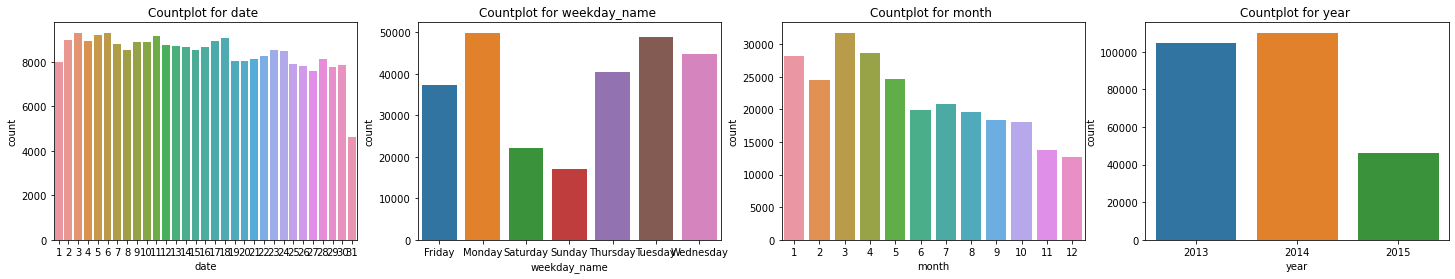

In [56]:
""" Analysing the count of all new columns based on the distinct values of quotation dates"""
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore") 
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25,4))
for j,i in enumerate(new_feat):
  plt.subplot(1, 4, j+1)
  sns.countplot(sorted(df[i]))
  plt.xlabel("count")
  plt.xlabel("{}".format(i))
  plt.title("Countplot for {} ".format(i))
plt.show()

### Observation:

The above represent the count of quoted dates for 3 year term
* From Date column, we can observe that number of quotation made to customer on date are not stable. However quotation made/prepared at the last day of the month is less (This could be because 31st day occurs only 5 times in a year)
* In weekday_name column,We see the higher quotation made on Monday(which is start of week) and conversion count goes decreasing for subsequent days
* In month column,Quotation made are higher in the January March & April and starts decreasing for the subsequent years. In Feb month. It could be less due to lesser number of days in Feb Month
* Higher quotation are made in 2014 and lesser in 2014 year

In [57]:
import numpy as np
quote_converted_1_all=[]
quote_not_converted_0_all=[]

for k in ['weekday_name','month','date','year']: #checking for new features quote conversion dependency
  quote_converted_1=[] #storing converted customers count in terms of new features
  quote_not_converted_0=[]
  total_quote=df['QuoteConversion_Flag'].count() #total number of quotes available
  for i in np.unique(df[k]):
    """ To get converted quotes from each Month, Day,Year,Date """
    value_1=df['QuoteConversion_Flag'][df[k]==i].sum() #concept: count of quote conversion for weekday = Monday,Tuesday
    value_0= total_quote-value_1  #to get the non converted quotes
    quote_converted_1.append(value_1)
    quote_not_converted_0.append(value_0)
  quote_converted_1_all.append(quote_converted_1)
  quote_not_converted_0_all.append(quote_not_converted_0)

<function matplotlib.pyplot.show(close=None, block=None)>

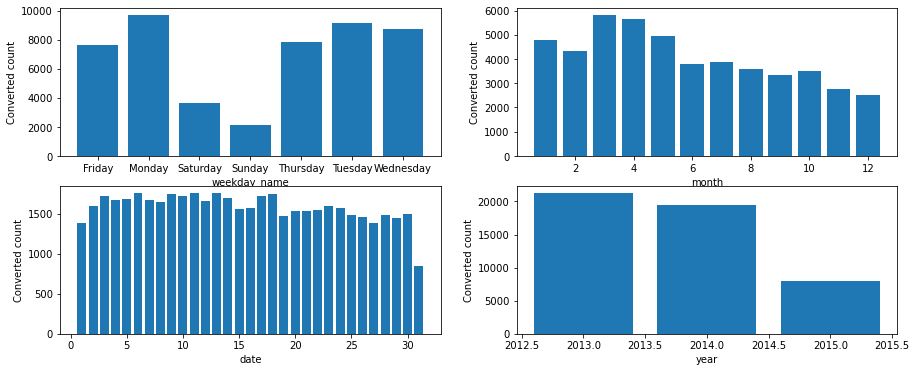

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
for j,k in enumerate(['weekday_name','month','date','year']):
  plt.subplot(2,2,j+1)  #splitting 2 2 row, 2 column & placement
  plt.bar(np.unique(df[k]),quote_converted_1_all[j])
  plt.xlabel(k)
  plt.ylabel("Converted count")
plt.show

### Observation:
* In weekday_name column,We see the higher quotation made on Monday(which is start of week) and conversion count goes decreasing for subsequent days
* In month column,Quotation made are higher in the January March & April and starts decreasing for the subsequent years. In Feb month. It could be less due to lesser number of days in Feb Month
* From Date column, we can observe that number of quotation sold/converted on customer on date are not stable. However converted quotation at the last day of the month is less (This could be because 31st day occurs only 5 times in a year)
* In 2013, 21343 number of customers are converted their quote to policy. foe the next subsequent years the conversion starts decreasing



In [60]:
y=df['QuoteConversion_Flag']
df=df.drop(['QuoteConversion_Flag','Original_Quote_Date'],axis=1)

In [61]:
#this train data contains without OHE features
df.to_csv('train_preprocessed_with NULL.csv')

In [ ]:
#loading data from storage without NULL values
import pandas as pd
import numpy as np
df_1 =pd.read_csv("train_preprocessed_with NULL.csv")

In [ ]:
X_test_data=pd.read_csv("test.csv")
X_test_data=X_test_data.drop(itemlist,axis=1)
print("test_data dimension is: ", X_test_data.shape)
X_test_data.columns